In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import math

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from utils.dataManagers.steward import DataSteward
from utils.dataManagers.informations import informer
from utils.clf_results import clfResult

ds = DataSteward('mapper_and_most_frequent', 'mean')
column_desc = informer.get_column_descriptions()

train = ds.train_data
test = ds.test_data
ytrain = ds.train_response

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso

def get_submission(predictions, predictions_file_name=None):
    df = pd.DataFrame(predictions, columns=['SalePrice'])
    df.index = test.index
    df[df.SalePrice < 0] = 0
    if predictions_file_name:
        df.to_csv(f'scores/{predictions_file_name}.csv')
    return df

def get_df_for_predictions(train, test):
    all_data = pd.concat((train, test))
    categorical = all_data.select_dtypes(['category'])  
    number_type = all_data.select_dtypes(['int64', 'float64']) 
    
    df = pd.get_dummies(categorical).join(number_type)
    return df.iloc[:train.shape[0], :], df.iloc[train.shape[0]:, :]

trainWithDummies, testWithDummies = get_df_for_predictions(train, test)

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
param_grid = dict(alpha=alphas)

In [3]:
clf = Ridge(normalize=True)
grid_ridge = GridSearchCV(clf, param_grid)
grid_ridge.fit(trainWithDummies, ytrain)

predictions = grid_ridge.predict(testWithDummies)
get_submission(predictions, 'ridge_normalized_alpha_tuned').head()

GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

,SalePrice
Id,
1461,113853.367766
1462,147668.438883
1463,184987.302361
1464,192471.257008
1465,212642.778402


In [4]:
results = clfResult(grid_ridge.best_estimator_, 'sth', trainWithDummies.columns,
                    grid_ridge.predict(testWithDummies), store_classifier=True, store_predictions=True)
results

In [7]:
def predict(clf, submission_name= None):
    grid = GridSearchCV(clf, param_grid)
    grid.fit(trainWithDummies, ytrain)

    predictions = grid.predict(testWithDummies)
    get_submission(predictions, submission_name).head()
    return grid

grid = predict(Lasso(), 'lasso_normalized_alpha_tuned')

c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

In [222]:
def add_clf_to_history(clf, name, history_df=pd.DataFrame(index=trainWithDummies.columns)):
    history_df[name] = clf.coef_
    return history_df


In [10]:
results = clfResult(grid.best_estimator_, 'lasso_sth', trainWithDummies.columns)
results

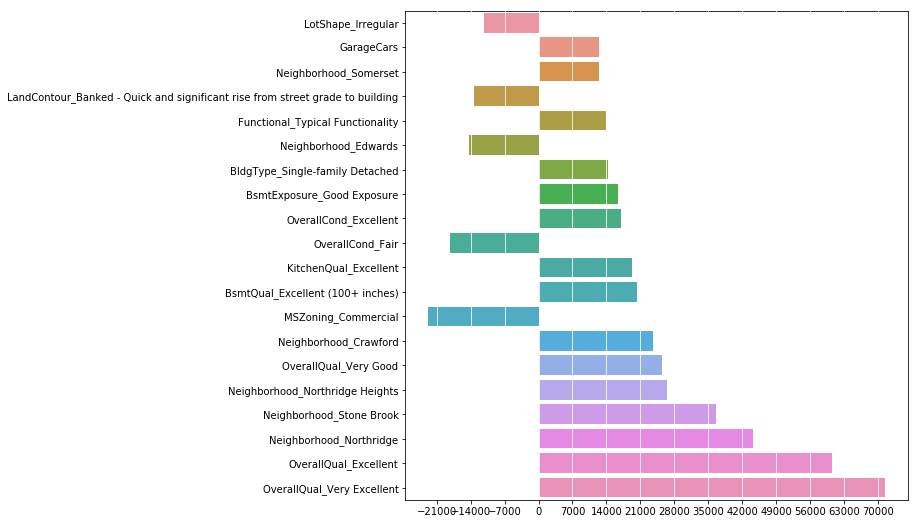

In [13]:
results.plot_best_predictors(20)

In [276]:
df['a'] = ser

In [274]:
ser = pd.Series(grid_lasso.best_estimator_.coef_, index=trainWithDummies.columns)
ser.head()

Alley_Gravel            -451.756147
Alley_No alley access      0.000000
Alley_Paved                0.000000
BldgType_2fmCon          122.077207
BldgType_Duplex           -0.000000
dtype: float64

In [ ]:
grid_lasso.best_estimator_.coef

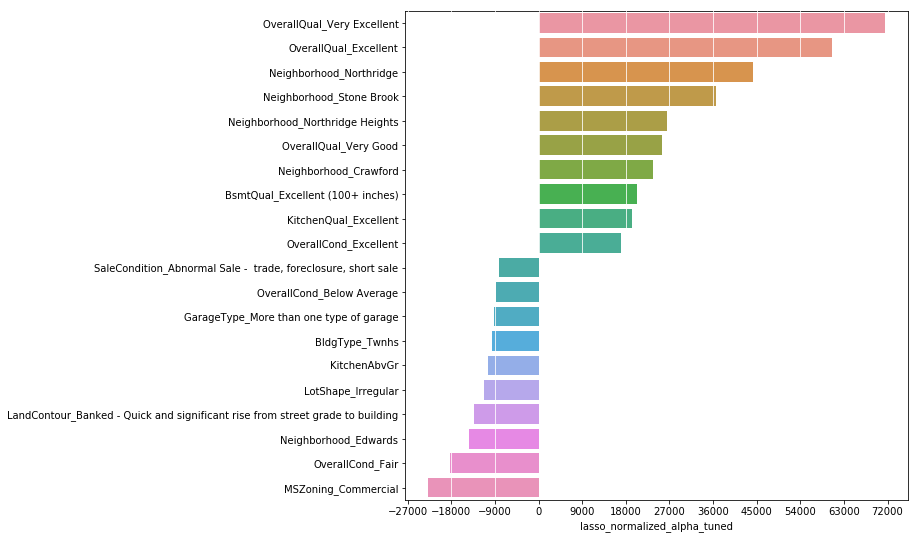

In [225]:
clf_history = add_clf_to_history(grid_laasso.best_estimator_, 'lasso_normalized_alpha_tuned')

best = get_best_predictors(clf_history.lasso_normalized_alpha_tuned, 10)
plot_best_predictoris(best, 9000)

In [269]:
def get_most_important_columns(series, columns_count=10):
    return list(np.abs(series).sort_values()[-columns_count:].index)

def get_excluded_columns(series):
    return list(series[series == 0].index)
    
get_most_important_columns(clf_history.lasso_normalized_alpha_tuned, 3)
get_excluded_columns(clf_history.lasso_normalized_alpha_tuned)[:3]

['Neighborhood_Northridge',
 'OverallQual_Excellent',
 'OverallQual_Very Excellent']

['Alley_No alley access', 'Alley_Paved', 'BldgType_Duplex']

In [242]:
clf = Ridge(normalize=True)
grid_ridge = GridSearchCV(clf, param_grid, scoring='neg_mean_squared_log_error')
grid_ridge.fit(trainWithDummies[most_important_columns], ytrain)

predictions = grid_ridge.predict(testWithDummies[most_important_columns])
get_submission(predictions, 'ridge_most_important_columns').head()

GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_log_error', verbose=0)

,SalePrice
Id,
1461,103887.891541
1462,148184.451577
1463,163091.129378
1464,192901.362288
1465,212370.592420
